<a href="https://colab.research.google.com/github/Jorgvt/AS_ProyectoFinal/blob/main/Data_Augmentation_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 2. Data Augmentation y Transfer Learning

En la práctica anterior hemos visto la aproximación más sencilla para resolver un problema de clasificación de imágenes utilizando redes convolucionales. En esta práctica vamos a ir un paso más allá introduciendo los conceptos de *Data Augmentation* y *Transfer Learning* para resolver un problema de clasificación en el que tendremos que diferenciar entre perros y gatos. Aunque puede parecer sencillo, este problema es bastante más complicado que el anterior porque existen perros y gatos muy diferentes.

Para comprobar cómo de efectivas son las nuevas técnicas primero estableceremos una *baseline* sin utilizarlas. Esta es una práctica muy habitual en la experimentación y muy importante, ya que es necesario que seamos capaces de determinar cuanto mejora o empeora un modelo al realizar ciertos cambios.

## Importación de las librerías

Antes de empezar a trabajar, cargamos todas las librerías que vamos a necesitar.

In [1]:
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds

In [2]:
## Opciones generales de Matplotlib para ajustar las figuras
plt.rcParams['figure.figsize'] = [9, 4]
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
## Este fragmento de código puede servir para solucionar algunos errores de CUDA
try:
    tf_gpus = tf.config.list_physical_devices('GPU')
    for gpu in tf_gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

## Carga de los datos

Para poder centrarnos en la parte interesante del ejercicio utilizaremos el dataset que se incluye en `tensorflow_datasets`. Podemos cargarlo utilizando la función `load()`. No todos los conjuntos de datos alojados en esta librería devuelven lo mismo al cargarlos, hay algunos que tienen varias versiones, otros que ya están divididos en entrenamiento y test, etc. Este en particular no tienen ninguna división, pero podemos utilizar el parámetro `split` para cargar directamente el dataset dividido de la siguiente manera:

> Hay que tener en cuenta que las divisiones se introducen como una lista de `string`s.

In [4]:
train, validation, test = tfds.load('cats_vs_dogs', with_info=False, 
                                    data_dir="./data/", 
                                    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'])

print(f"Muestras de entrenamiento: {len(train)}.")
print(f"Muestras de validación: {len(validation)}.")
print(f"Muestras de test: {len(test)}.")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to ./data/cats_vs_dogs/4.0.0.incomplete1SIBJP/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to ./data/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Muestras de entrenamiento: 16283.
Muestras de validación: 3490.
Muestras de test: 3489.


Esta función nos devuelve tres objetos `PrefetchDataset` de *TensorFlow*. Estos objetos pueden parecer un poco incómodos, pero tienen características muy útiles con las que nos tendremos que acostumbrar a trabajar. La más útil para nosotros es que permiten cargar los datos en memoria únicamente cuando se van a utilizar, por lo que podemos trabajar con conjuntos de datos muy grandes.

Para agilizar los entrenamientos y el desarrollo de la práctica vamos a utilizar un subconjunto de los datos. Se recomienda al lector repetir la práctica con todos los datos y comprobar cómo afecta la cantidad de datos a los resultados que se obtienen.

Para obtener un subset a partir de un `tf.data.Dataset` podemos utilizar el método `.take()`, que permite extraer tantos elementos como queramos del dataset original. Podemos utilizar `.shuffle()` primero para barajar los ejemplos en caso de que lo consideremos oportuno. Vamos a realizar el ejercicio utilizando 4000 muestras de entrenamiento, 500 de validación y 500 de test.

> Todos los métodos que se aplican sobre un `tf.data.Dataset` devuelven otro objeto del mismo tipo, por lo que es muy cómodo realizar este tipo de operaciones y encadenarlas.

In [5]:
N_train = 8000
N_val = 1000
N_test = 1000

train_red = train.take(N_train)
validation_red = validation.take(N_val)
test_red = test.take(N_test)

### Exploración de los datos


Estos objetos no se pueden indexar, pero sí que se puede iterar sobre ellos. Además, cada elemento es un diccionario de Python que contendrá diferente información en función del dataset que hayamos cargado. Veamos qué contiene el nuestro:

In [6]:
for sample in train_red:
    break
sample.keys()

dict_keys(['image', 'image/filename', 'label'])

Contiene tres elementos:

- La imagen en cuestión.
- La ubicación de la imagen en el sistema.
- La etiqueta de la imagen.

Más adelante, en la práctica de segmentación, trabajaremos con otro conjunto de datos que incluye más información todavía. Vamos a representar nuestra imagen:

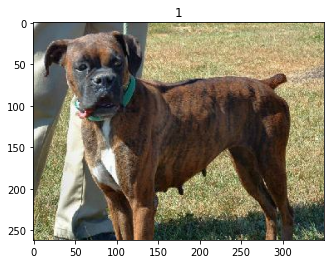

In [7]:
plt.figure()
plt.imshow(sample['image'])
plt.title(sample['label'].numpy())
plt.show()

Como ya sabemos, es muy importante conocer los rangos en los que se encuentran los valores de los píxeles que vamos a introducir en nuestra red neuronal. Al tratarse de una imagen a color sabemos que vamos a trabajar con tres canales, así que tenemos que comprobar el rango de los tres canales:

In [8]:
maxs = sample['image'].numpy().max(axis=(0,1))
mins = sample['image'].numpy().min(axis=(0,1))
ranges = [(m, M) for m, M in zip(mins, maxs)]

print("Rangos: {}, {}, {}".format(*ranges))

Rangos: (0, 255), (0, 255), (0, 255)


También es buena idea comprobar las dimensiones de la imagen con la que estamos trabajando y comprobar si todas las imágenes tienen las mismas dimensiones. Esto último es algo especialmente crítico, ya que podría ocasionarnos errores en el futuro que pueden ser difíciles de identificar.

In [9]:
sample['image'].shape

TensorShape([262, 350, 3])

Una forma rápida de identificar si tenemos diferentes tamaños de imágenes es recorrer el dataset guardando en una lista el atributo `.shape` de la imagen. Luego obtenemos los valores únicos con `set()` y contamos la cantidad de elementos. Este método es curioso porque presenta un uso del objeto `set()`, aunque en realidad nos valdría simplemente con comprobar las dimensiones de dos imágenes consecutivas y comprobar si son iguales o no.

In [10]:
shapes = []
for s in train_red:
    shapes.append(s['image'].numpy().shape)

In [11]:
len(set(shapes))

2817

**Ejercicio: Para elegir una transformación adecuada puede ser útil conocer la distribución de dimensiones de nuestro conjunto de datos. Obtén la cantidad de veces que aparece cada dimensión distinta.**

In [12]:
# ## SOLUCIÓN ##
# Counter(shapes)

Por último vamos a comprobar también que las etiquetas que tenemos son las correctas y su distribución. Para este problema esperaríamos tener solamente dos etiquetas, 0 y 1, que representasen gato o perro. Comprovémoslo:

In [13]:
labels_train = [sample['label'].numpy() for sample in train_red]
labels_val = [sample['label'].numpy() for sample in validation_red]
labels_test = [sample['label'].numpy() for sample in test_red]

print(Counter(labels_train))
print(Counter(labels_val))
print(Counter(labels_test))

Counter({1: 4017, 0: 3983})
Counter({0: 518, 1: 482})
Counter({1: 510, 0: 490})


Vemos que solamente tenemos las dos etiquetas que esperábamos y, además, parecen estar distribuidas de forma más o menos equitativa, por lo que no deberíamos tener problema de desbalanceo de clases.

### Preprocesado de los datos

Como era de esperar, las imágenes se encuentran dentro del rango $[0, 255]$, por lo que tendremos que normalizarlas. Además, las imágenes tienen diferentes tamaños. Por otra parte, tal y como están los conjuntos de datos no podemos utilizarlos para el entrenamiento (no podemos utilizar diccionarios en el método `.fit()`). Tenemos que transformarlos en conjuntos que solo tengan las imágenes para poder introducirlos como argumentos del método `.fit()` y poder entrenar fácilmente los modelos que definamos. Para ello vamos a definir una función `prepare_data()` que aplicaremos a todo el conjunto mediante el método `.map()`. Este método es muy útil porque permite aplicar funciones a todo el conjunto de datos de forma muy sencilla.

La función `prepare_data()` simplemente se encargará de extraer la imagen y la etiqueta correspondiente de cada diccionario y devolverla. También podemos aprovechar para normalizarlas y transformar las imágenes para que tengan todas el mismo tamaño. 

Cada método que se aplica sobre los objetos `Dataset` de *TensorFlow* devuelve otro `Dataset`, lo que facilita mucho aplicar transformaciones consecutivas para preparar nuestros datos de la forma más cómoda.

In [14]:
def prepare_data(sample, reshape_dims=(128, 128)):
    
    image = sample['image']
    label = sample['label']

    image = image/255
    image = tf.image.resize(image, size=reshape_dims)

    return image, label

In [15]:
train_rdy = train_red.map(prepare_data)
validation_rdy = validation_red.map(prepare_data)
test_rdy = test_red.map(prepare_data)

Siempre es buena idea comprobar si hemos obtenido el resultado esperado:

In [16]:
for img, label in train_rdy:
    maxs = img.numpy().max(axis=(0,1))
    mins = img.numpy().min(axis=(0,1))
    ranges = [(m, M) for m, M in zip(mins, maxs)]

    print("Rangos: {}, {}, {}".format(*ranges))
    print(f"Dimensiones : {img.shape}")
    break

Rangos: (0.0, 1.0), (0.017385684, 0.9953764), (0.0, 0.99994713)
Dimensiones : (128, 128, 3)


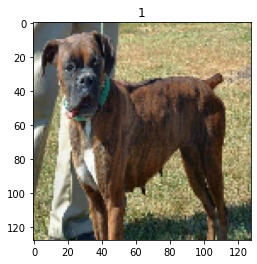

In [17]:
plt.figure()
plt.imshow(img)
plt.title(label.numpy())
plt.show()

Una vez que hemos preparado los conjuntos de entrenamiento podemos pasar a la definición de nuestro modelo *baseline*.

### Generalidades

Durante esta práctica vamos a entrenar y comparar muchos modelos. Para realizar estas comparaciones vamos a representar sus dinámicas de entrenamiento (es una buena forma de apreciar el sobre-entrenamiento) y también calcularemos sus métricas (pérdida y precisión) en los diferentes conjuntos que hemos creado anteriormente. Por todo esto es buena idea definir previamente unas funciones genéricas que nos sirvan para hacer esto de forma mucho más rápida y limpia.

In [18]:
def plot_history(history):

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], 'k-o', label = "Entrenamiento")
    plt.plot(history.history['val_loss'], 'k--*', label = "Validación")
    plt.ylabel('Loss')
    plt.xlabel('Épocas')
    plt.title('Loss del modelo')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.array(history.history['accuracy'])*100, 'k-o', label="Entrenamiento")
    plt.plot(np.array(history.history['val_accuracy'])*100, 'k--*', label="Validación")
    plt.ylabel('% Tasa de acierto')
    plt.xlabel('Épocas')
    plt.title('Tasa de acierto del modelo')
    plt.legend()

    return

In [19]:
def evaluate_model(model, train, validation, test, 
                   batch_size=256, verbose=True):

    eval_train = model.evaluate(train.batch(batch_size), verbose=0)
    eval_val = model.evaluate(validation.batch(batch_size), verbose=0)
    eval_test = model.evaluate(test.batch(batch_size), verbose=0)

    if verbose:
        print("[Entrenamiento] Loss: {:0.3f} | Accuracy: {:0.3f}".format(*eval_train))
        print("[Validación] Loss: {:0.3f} | Accuracy: {:0.3f}".format(*eval_val))
        print("[Test] Loss: {:0.3f} | Accuracy: {:0.3f}".format(*eval_test))

    return eval_train, eval_val, eval_test

## Modelo *Baseline* (Sin Data Augmentation ni Transfer Learning)

Como base vamos a tomar el modelo utilizado en la práctica anterior, definido mediante la API Secuencial, pero introduciremos dos cambios fundamentales:

- Ahora estamos trabajando en un problema binario, por lo que la capa final tendrá que ser una `Dense` de una neurona a la cual aplicaremos la función sigmoide. De esta forma obtenemos un valor que representa la probabilidad de pertenecer a la clase positiva, es decir, la probabilidad de que la etiqueta sea 1. 

- Tenemos que utilizar una función de coste diferente. Ahora utilizaremos `tf.losses.BinaryCrossentropy()`.

In [20]:
model = tf.keras.models.Sequential([
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same',
                  input_shape=(128,128,3)),
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=2),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid")
])

In [21]:
model.compile(optimizer="adam", loss="binary_crossentropy", 
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 65536)             0

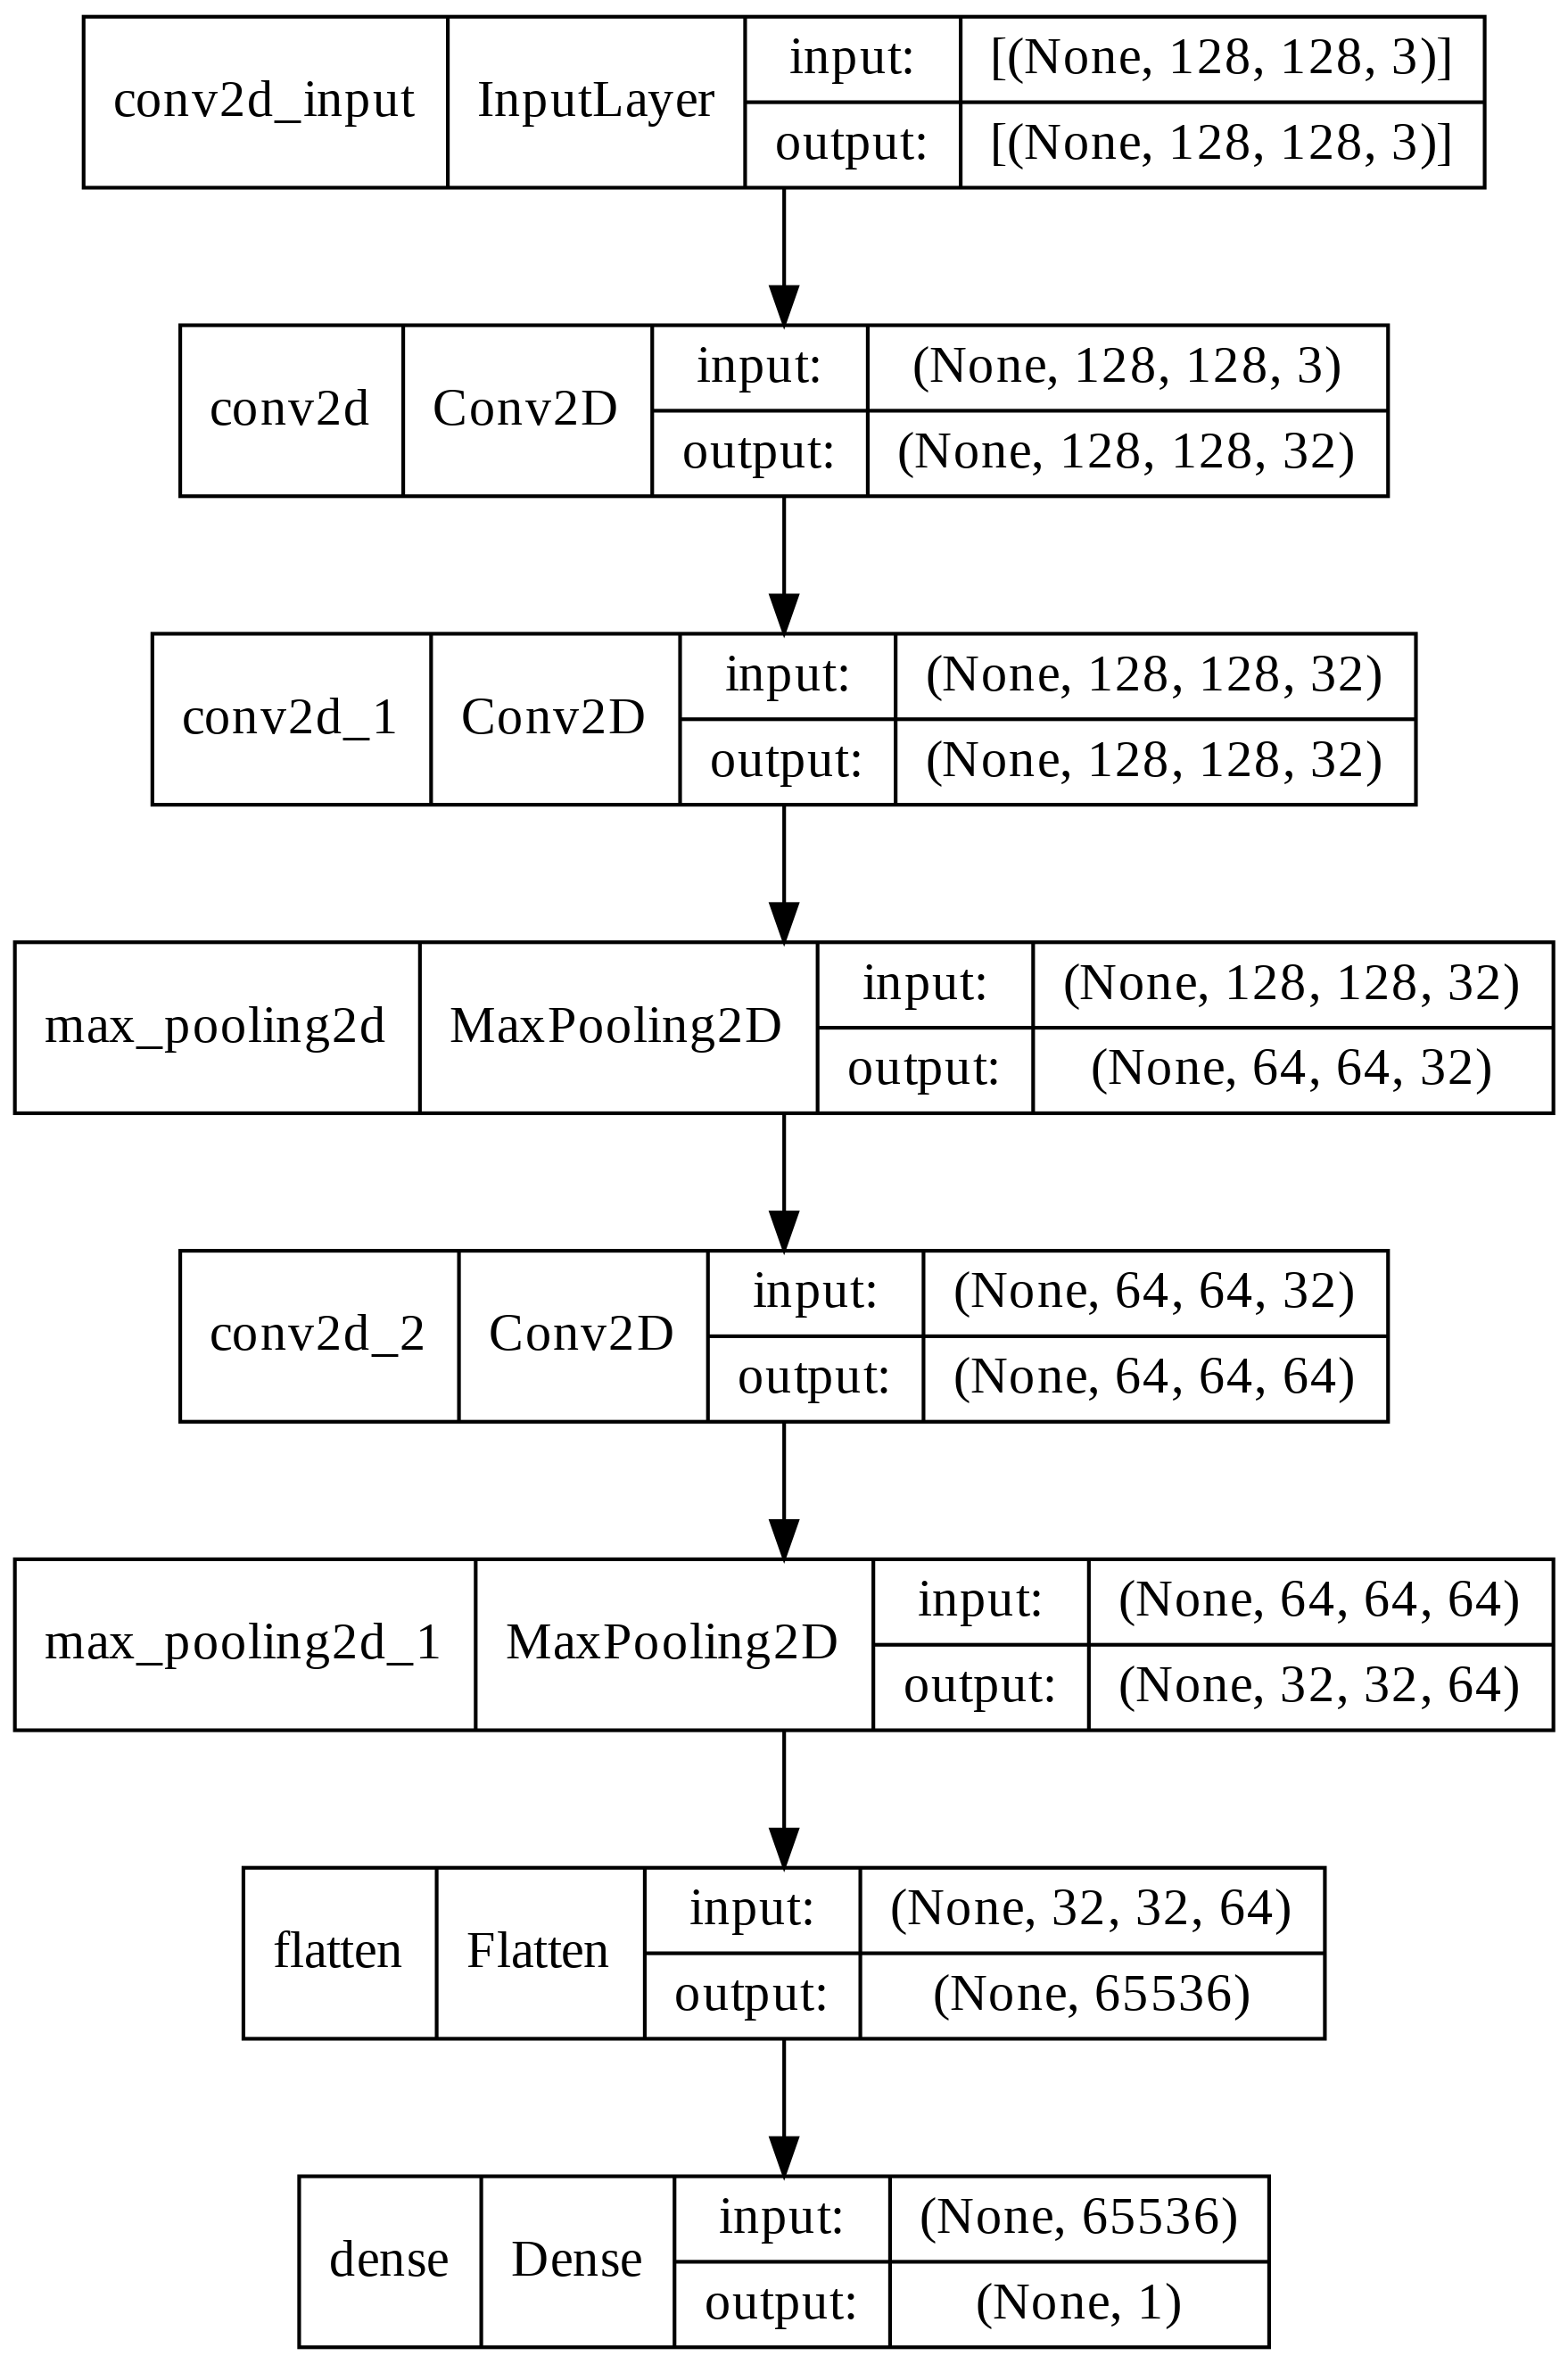

In [23]:
plot_model(model, to_file='Images/cnn_baseline.png', show_shapes=True,dpi=300)

## Entrenamiento del modelo

Como ya hemos preparado anteriormente nuestros conjuntos de datos, ahora solamente es necesario utilizar el método `.fit()` del modelo que acabamos de definir. Al estar trabajando con un `tf.data.Dataset`, no es necesario especificar los valores de X ni de Y, internamente la librería ya se encarga de obtenerlos a partir del objeto que le pasamos. Utilizaremos los mismos parámetros de entrenamiento que en la práctica anterior:

In [24]:
history = model.fit(train_rdy.batch(64), 
                    epochs=10, 
                    validation_data=validation_rdy.batch(64))

Epoch 1/10
125/125 [==============================] - 32s 179ms/step - loss: 0.6703 - accuracy: 0.5916 - val_loss: 0.7496 - val_accuracy: 0.5480
Epoch 2/10
125/125 [==============================] - 21s 168ms/step - loss: 0.5887 - accuracy: 0.6851 - val_loss: 0.6139 - val_accuracy: 0.6410
Epoch 3/10
125/125 [==============================] - 21s 170ms/step - loss: 0.5328 - accuracy: 0.7321 - val_loss: 0.6015 - val_accuracy: 0.6810
Epoch 4/10
125/125 [==============================] - 21s 170ms/step - loss: 0.4821 - accuracy: 0.7629 - val_loss: 0.5719 - val_accuracy: 0.7140
Epoch 5/10
125/125 [==============================] - 22s 171ms/step - loss: 0.4305 - accuracy: 0.7994 - val_loss: 0.5390 - val_accuracy: 0.7310
Epoch 6/10
125/125 [==============================] - 21s 170ms/step - loss: 0.3764 - accuracy: 0.8289 - val_loss: 0.5403 - val_accuracy: 0.7480
Epoch 7/10
125/125 [==============================] - 21s 169ms/step - loss: 0.3264 - accuracy: 0.8585 - val_loss: 0.5597 - val_ac

Una vez completado el entrenamiento representamos las dinámicas de entrenamiento a partir de `history`.

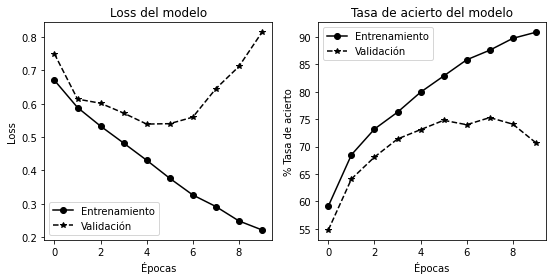

In [25]:
plot_history(history)
# plt.savefig("Images/Training_CNN_Baseline.png")
plt.show()

Esta figura nos permite ver que, si bien el modelo elegido es capaz de aprenderse los datos del conjunto de entrenamiento, no tiene la capacidad suficiente como para generalizar. Estamos ante un ejemplo claro de sobre ajuste: el rendimiento en el conjunto de entrenamiento mejora mientras que el rendimiento en validación no cambia o incluso empeora. 

Una solución a este problema es aplicar técnicas de regularización a los pesos (L1, L2 y Dropout) o *Data Augmentation*. El aumento de los datos dificulta que el modelo aprenda a memorizar los datos de entrenamiento y favorece una mejor capacidad de generalización, por lo que también se puede considerar una técnica de regularización. Esto quiere decir que habrá que tener cuidado de no aumentar demasiado los datos o podríamos perder rendimiento si alteramos demasiado las imágenes originales.

El aumento de los datos puede servir como una forma de paliar la falta de datos, pero necesitamos partir de una cantidad suficiente de datos para obtener mejoras considerables y resultados significativos.

### Evaluación del modelo

El método `.evaluate()` permite calcular todas las métricas que hemos compilado anteriormente en el modelo sobre el conjunto de datos que queramos. Es una buena práctica evaluar el modelo en los diferentes conjuntos de datos al acabar el entrenamiento para obtener una métrica final del trabajo realizado. Este método nos devuelve una lista con las métricas, en este caso la función de coste y la precisión:

> A la hora de hacer la evaluación podemos utilizar tamaños del batch distintos a los de entrenamiento porque no vamos a actualizar los pesos y no afectará al rendimiento del modelo.

In [26]:
metrics_baseline = evaluate_model(model, train_rdy, validation_rdy, test_rdy)

[Entrenamiento] Loss: 0.311 | Accuracy: 0.858
[Validación] Loss: 0.814 | Accuracy: 0.707
[Test] Loss: 0.807 | Accuracy: 0.707


### Callbacks: `EarlyStopping` y `ModelCheckpoint`

Hasta ahora hemos estado trabajando con un conjunto de entrenamiento, uno de validación y otro de test, pero en realidad no hemos utilizado el conjunto de validación para nada en particular. El uso más habitual de este conjunto es el de detener el entrenamiento cuando deja de mejorar la métrica de interés. De esta forma podemos olvidarnos de tener que ajustar la cantidad de épocas durante las cuales queremos entrenar el modelo: utilizaremos una cantidad de épocas suficientemente grande como para alcanzar el sobre ajuste y detendremos el entrenamiento cuando se empiece a producir.

Para hacer esto podemos utilizar dos callbacks: `EarlyStopping` y `ModelCheckpoint`. Un callback simplemente es una función que se ejecuta en puntos determinados del entrenamiento, por ejemplo, estos dos callbacks comprueban el valor de una determinada métrica al final de cada época y toman una acción determinada:

- `EarlyStopping`: detiene el entrenamiento si hace más de `N` épocas que no mejora la métrica. Resulta útil para evitar el sobre ajuste y reducir el tiempo innecesario de cálculo.
- `ModelCheckpoint`: guarda los pesos del modelo si se mejora la métrica en cuestión. Es útil tanto como para evitar el sobre ajuste como para poder continuar un entrenamiento que se ha cortado por algún fallo de la máquina.

Podemos elegir cualquier métrica (o función de coste) para tomar estas decisiones, aunque la recomendación habitual es utilizar la métrica que realmente nos interesa optimizar. En este problema de clasificación lo que nos interesa es alcanzar el mejor valor posible de la precisión, por lo que controlaremos la `val_accuracy`.

Ser capaces de definir nuestros propios callbacks puede darnos mucha flexibilidad durante el entrenamiento, aunque es algo más avanzado que queda fuera del alcance de esta práctica. Para utilizarlos en el entrenamiento de un modelo simplemente tendremos que pasar una lista de callbacks al parámetro `callbacks` del método `.fit()`:

In [27]:
model = tf.keras.models.Sequential([
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same',
                  input_shape=(128,128,3)),
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=2),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid")
])

In [28]:
model.compile(optimizer="adam", loss="binary_crossentropy", 
              metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 65536)            

In [29]:
## Definición de los callbacks
cb_earlystopping = tf.keras.callbacks.EarlyStopping(patience=4,
                                                    monitor='val_accuracy')
cb_modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath='model_cnn_baseline.h5',
                                                        monitor='val_accuracy',
                                                        save_best_only=True)
## Entrenamiento del modelo
history = model.fit(train_rdy.batch(64), 
                    epochs=50, 
                    validation_data=validation_rdy.batch(64),
                    callbacks=[cb_earlystopping, cb_modelcheckpoint])

Epoch 1/50
125/125 [==============================] - 22s 169ms/step - loss: 0.6855 - accuracy: 0.5859 - val_loss: 0.7733 - val_accuracy: 0.5410
Epoch 2/50
125/125 [==============================] - 21s 169ms/step - loss: 0.6242 - accuracy: 0.6604 - val_loss: 0.6700 - val_accuracy: 0.6140
Epoch 3/50
125/125 [==============================] - 21s 168ms/step - loss: 0.5659 - accuracy: 0.7067 - val_loss: 0.6774 - val_accuracy: 0.6570
Epoch 4/50
125/125 [==============================] - 21s 169ms/step - loss: 0.5029 - accuracy: 0.7541 - val_loss: 0.6179 - val_accuracy: 0.6990
Epoch 5/50
125/125 [==============================] - 21s 169ms/step - loss: 0.4406 - accuracy: 0.7928 - val_loss: 0.5319 - val_accuracy: 0.7350
Epoch 6/50
125/125 [==============================] - 21s 168ms/step - loss: 0.3778 - accuracy: 0.8298 - val_loss: 0.5588 - val_accuracy: 0.7300
Epoch 7/50
125/125 [==============================] - 22s 171ms/step - loss: 0.3164 - accuracy: 0.8695 - val_loss: 0.6042 - val_ac

Vemos que aunque hemos configurado el entrenamiento para que durase 50 épocas, se ha cortado automáticamente en la época 10 reduciendo enormemente el tiempo perdido sobre ajustando el modelo. Una vez el entrenamiento se detiene hay que recordar cargar los pesos del mejor modelo y evaluar los resultados:

In [30]:
model.load_weights('model_cnn_baseline.h5')

In [31]:
metrics_baseline_cb = evaluate_model(model, train_rdy, validation_rdy, test_rdy)

[Entrenamiento] Loss: 0.258 | Accuracy: 0.901
[Validación] Loss: 0.604 | Accuracy: 0.743
[Test] Loss: 0.567 | Accuracy: 0.757


In [32]:
# eval_train = model.evaluate(train_rdy.batch(256), verbose=0)
# eval_val = model.evaluate(validation_rdy.batch(256), verbose=0)
# eval_test = model.evaluate(test_rdy.batch(256), verbose=0)

# print("[Entrenamiento] Loss: {:0.3f} | Accuracy: {:0.3f}".format(*eval_train))
# print("[Validación] Loss: {:0.3f} | Accuracy: {:0.3f}".format(*eval_val))
# print("[Test] Loss: {:0.3f} | Accuracy: {:0.3f}".format(*eval_test))

Con este sencillo cambio vemos que se puede mejorar bastante el rendimiento final del modelo mientra reducimos el tiempo de cálculo desperdiciado. A partir de ahora utilizaremos estos callbacks en todos los entrenamientos.

### Grad-CAM

Como vemos la red tiene un fallo alto en esta imagen, vamos a ver en que se está fijando para dar las predicciones de algunos gatos y perros y ver en que se está basando. Para ello utilizaremos Gradient Class Activation Map. https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759

In [33]:
import tensorflow as tf

def find_ind_last_conv2D(model):
    ind_last_conv2D_layer = None
    for i,x in enumerate(model.layers):
        if x.__class__.__name__ == "Conv2D":
            ind_last_conv2D_layer = i
    return ind_last_conv2D_layer


def show_heatmap(model, im):
    imag = np.expand_dims(im, axis=0) # de 1 imagen pasamos a 1 conjunto de 1 imagen
        
    # The is the output feature map of the last convolutional layer
    last_conv_layer = model.layers[find_ind_last_conv2D(model)]
    
    # This is the gradient of the "benign" class with regard to
    # the output feature map of last convolutional layer
    with tf.GradientTape() as tape:
        aux = model.output
        #aux = model.layers[-2].output # salida de la última capa densa antes de softmax

        iterate = tf.keras.models.Model([model.inputs], [aux, last_conv_layer.output])
        model_out, last_conv_layer = iterate(imag)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)

        # mean intensity of the gradient over a specific feature map channel:
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)    
    heatmap = np.maximum(heatmap, 0) # se quitan los negativos (se ponen a 0)
    heatmap /= np.max(heatmap) # se normaliza entre 0 y 1
    heatmap = heatmap[0] # pasamos de 1 conjunto de 1 heatmap a 1 heatmap
    
    # We use cv2 to load the original image
    #img = cv2.imread(img_path)
    img = imag[0]
    
    img = np.zeros((im.shape[0],im.shape[1],3))
#    print(im.shape, imag.shape)
    for i in range(3):
        img[:,:,i] = imag[0,:,:,0]

    
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    
    # We apply the heatmap to the original image
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) / 255
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_BONE) / 255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT) / 255
    
    
    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.5 + 0.5*im
    #print(heatmap.min(), heatmap.max(), heatmap.mean(), heatmap.std())
    #print(img.min(), img.max(), img.mean(), img.std())
    #print(superimposed_img.min(),  superimposed_img.max(),
    #      superimposed_img.mean(), superimposed_img.std())
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(im, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,3)
    plt.imshow(superimposed_img, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.show()
    #print(np.shape(imag))
    prob = 100*model.predict(imag)[0][class_indices["cats"]]
    print("Probabilidad clase gato : {:2.1f}%".format(prob))
    prob = 100*model.predict(imag)[0][class_indices["dogs"]]
    print("Probabilidad clase perro: {:2.1f}%".format(prob))
    print("\n\n")
    return heatmap, superimposed_img

Vamos primeros con los gatos que se equivoca del conjunto de test

In [34]:
y_pred_proba = model.predict(test_generator2)

NameError: ignored

In [ ]:
inds = np.where(y_te[:,class_indices["cats"]]==1)[0]
inds = sorted(inds, key=lambda i:y_pred_proba[i,class_indices["cats"]])
for i in inds[:10]:
    show_heatmap(model, X_te[i])

En algunos de los gatos vemos que se equivoca porque los localiza en exteriores que es donde suelen estar los perros

In [ ]:
inds = np.where(y_te[:,class_indices["dogs"]]==1)[0]
inds = sorted(inds, key=lambda i:y_pred_proba[i,class_indices["dogs"]])
for i in inds[:10]:
    show_heatmap(model, X_te[i])

Y lo mismo con los perros que se equivoca, los localiza en interiores, o quizás son más pequeños (tamaño de un gato).

Una forma de solucionar esto es utilizar Data Augmentation, así que vamos con ello (también la otra opción sería resamplear el dataset con gatos y perros que estuvieran en interior y exterior).

## Data Augmentation

Como ya sabemos, el aumento de los datos o *Data Augmentation* consiste en introducir alteraciones en las imágenes de nuestro conjunto de datos para obtener un conjunto de datos *aumentado* que contenga imágenes más diversas que favorezcan la generalización de los modelos. Hay una infinidad de transformaciones posibles que se pueden aplicar, pero algunas de ellas son:

- Rotaciones
- Traslaciones
- Cortes
- Zoom
- Volteados

Hasta hace relativamente poco tiempo se recomiendaba utilizar el objeto `tf.keras.preprocessing.image.ImageDataGenerator()` para utilizar *Data Augmentation*, pero esto ha cambiado con las últimas versiones de *Keras*. El enfoque más actual consiste en utilizar un `tf.data.Dataset` para gestionar la carga de los datos (que es lo que hemos hecho en la parte de carga de datos) y utilizar las capas de preprocesado para aplicar el aumento de los datos. Por medio de estas capas se pueden aplicar todas las transformaciones que hemos comentado:

- `tf.keras.layers.RandomRotation()`
- `tf.keras.layers.RandomTranslation()`
- `tf.keras.layers.RandomCrop()`
- `tf.keras.layers.RandomZoom()`
- `tf.keras.layers.RandomFlip()`

Esta nueva herramienta permite plantear de dos formas distintas el proceso de aumento:

- Podemos añadir las capas que queramos a nuestro modelo y entrenarlo como un modelo normal. Esto es lo más sencillo. Además, las capas están configuradas para dejar de funcionar al realizar la inferencia, por lo que no supondrán un problema.

- Podemos definir un modelo secuencial que implemente todas las transformaciones que queramos y aplicarlo sobre el `tf.data.Dataset` que ya hemos definido utilizando el método `.map()`. Esto es ligeramente más laborioso pero da más libertad a la hora de gestionar los recursos computacionales, por lo que se puede optimizar para acelerar los entrenamientos. 

Optaremos por el segundo enfoque y dejaremos el primero como ejercicio para el lector.

> Hay que tener en cuenta que todas estas transformaciones tienen parámetros que habrá que ajustar correctamente para obtener el mejor resultado posible. Puede haber casos en los que no tenga sentido aplicar ciertas transformaciones, por ejemplo, si queremos entrenar un clasificador de paisajes no tiene sentido voltear las imágenes verticalmente porque no existen ese tipo de paisajes.

> Nótese que el parámetro `factor` de la capa `RandomRotation()` se multiplica por 2$\pi$ para determinar, en radiantes, el rango de rotación de las imágenes: $(-factor*2\pi, factor*2\pi)$.

In [35]:
augmentations = tf.keras.models.Sequential([
    layers.RandomRotation(factor=0.35, fill_mode='reflect'),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='reflect'),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1, fill_mode='reflect'),
    layers.RandomFlip(mode='horizontal')
])

Un detalle muy importante a tener en cuenta cuando apliquemos *Data Augmentation* es que solamente hay que hacerlo sobre el conjunto de entrenamiento. Los conjuntos de validación y test están creados con la intención de tener unos datos fijos sobre los que probar nuestro modelo, por lo que no tiene sentido introducirles variaciones aleatorias a los datos de estos conjuntos.

In [36]:
train_aug = train_rdy.map(lambda x, y: (augmentations(x), y))

Antes de pasar al entrenamiento del modelo podemos comprobar el resultado de estas transformaciones sobre una imagen:

In [37]:
aug_sample = [next(iter(train_aug))[0] for i in range(12)]

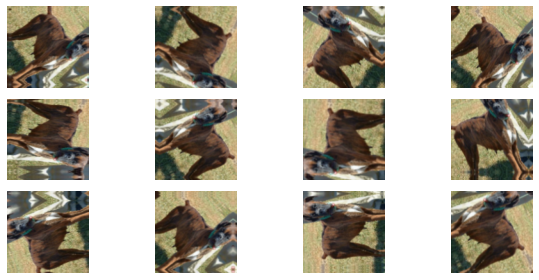

In [38]:
plt.figure()
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(aug_sample[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

Lo primero que vemos es que hay algunas imágenes que están muy deformadas. Esto sucede cuando la transformación deja un hueco en blanco en la imagen al hacer, por ejemplo, una rotación. Entonces el hueco se rellena conforme al parámetro `fill_mode` que hayamos seleccionado en cada capa.

**Ejercicio: Prueba varios tipos de `fill_mode` y elige el que más te guste. Luego comprueba si influyen mucho en los resultados que se obtienen.**

### Entrenamiento del modelo

Ahora que ya hemos definido todas las transformaciones que vamos a aplicar a los datos podemos pasar al entrenamiento del modelo para comprobar si estos cambios influyen en los resultados que obtenemos. Hay que recordar que tenemos que volver a definir el modelo para evitar utilizar los pesos entrenados en el apartado anterior.

> Es normal que este entrenamiento tarde bastante más tiempo que el anterior. Ahora cada imagen se procesa antes de entrar en el modelo y esto tiene cierta carga computacional.

In [39]:
model_aug = tf.keras.models.Sequential([
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same',
                  input_shape=(128,128,3)),
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=2),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid")
])

In [40]:
model_aug.compile(optimizer="adam", loss="binary_crossentropy", 
              metrics=["accuracy"])
model_aug.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 65536)            

A la hora de trabajar con *Data Augmentation* es recomendable aumentar la cantidad de épocas que dejamos pasar antes de detener el entrenamiento (la paciencia) porque es normal que fluctúen más las métricas. Esto se debe principalmente a que en cada época las transformaciones de los datos son distintas, por lo que los resultados puedes oscilar más.

In [41]:
## Definición de los callbacks
cb_earlystopping = tf.keras.callbacks.EarlyStopping(patience=8,
                                                    monitor='val_accuracy')
cb_modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath='model_cnn_aug.h5',
                                                        monitor='val_accuracy',
                                                        save_best_only=True)

## Entrenamiento del modelo
history_aug = model_aug.fit(train_aug.batch(64), 
                            epochs=50, 
                            validation_data=validation_rdy.batch(64),
                            callbacks=[cb_earlystopping, cb_modelcheckpoint])

Epoch 1/50
125/125 [==============================] - 69s 544ms/step - loss: 0.7009 - accuracy: 0.5598 - val_loss: 0.7162 - val_accuracy: 0.5230
Epoch 2/50
125/125 [==============================] - 68s 545ms/step - loss: 0.6721 - accuracy: 0.5910 - val_loss: 0.6788 - val_accuracy: 0.6120
Epoch 3/50
125/125 [==============================] - 68s 546ms/step - loss: 0.6509 - accuracy: 0.6258 - val_loss: 0.7573 - val_accuracy: 0.5260
Epoch 4/50
125/125 [==============================] - 68s 546ms/step - loss: 0.6427 - accuracy: 0.6379 - val_loss: 0.6866 - val_accuracy: 0.5850
Epoch 5/50
125/125 [==============================] - 68s 545ms/step - loss: 0.6157 - accuracy: 0.6601 - val_loss: 0.6616 - val_accuracy: 0.6100
Epoch 6/50
125/125 [==============================] - 68s 546ms/step - loss: 0.6099 - accuracy: 0.6681 - val_loss: 0.6887 - val_accuracy: 0.5910
Epoch 7/50
125/125 [==============================] - 68s 546ms/step - loss: 0.6014 - accuracy: 0.6750 - val_loss: 0.6310 - val_ac

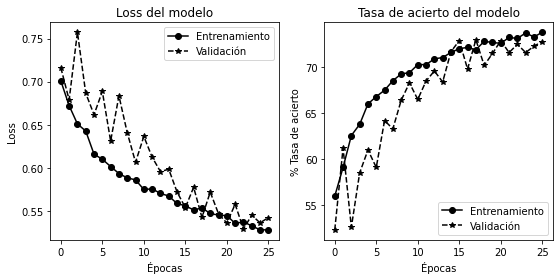

In [42]:
plot_history(history_aug)
# plt.savefig("Images/Training_CNN_DataAugmentation.png")
plt.show()

La figura superior ejemplifica a la perfección el resultado de haber aplicado regularizacion al modelo. Mientras que en el entrenamiento anterior habíamos alcanzado el sobre ajuste en la tercera época, en este caso parece que después de 50 épocas aún podríamos seguir entrenando el modelo. Por contra, la evolución de la precisión es mucho menor. Esta ralentización del aprendizaje se produce porque todas las transformaciones que hemos introducido hacen que el aprendizaje sea más complicado, por lo que suele ser necesario utilizar más épocas para entrenar los modelos.

### Evaluación del modelo

El método `.evaluate()` permite calcular todas las métricas que hemos compilado anteriormente en el modelo sobre el conjunto de datos que queramos. Es una buena práctica evaluar el modelo en los diferentes conjuntos de datos al acabar el entrenamiento para obtener una métrica final del trabajo realizado. Este método nos devuelve una lista con las métricas, en este caso la función de coste y la precisión:

> A la hora de hacer la evaluación podemos utilizar tamaños del batch distintos a los de entrenamiento porque no vamos a actualizar los pesos y no afectará al rendimiento del modelo.

In [43]:
model_aug.load_weights('model_cnn_aug.h5')

In [44]:
metrics_aug = evaluate_model(model_aug, train_rdy, validation_rdy, test_rdy)

[Entrenamiento] Loss: 0.517 | Accuracy: 0.749
[Validación] Loss: 0.542 | Accuracy: 0.730
[Test] Loss: 0.510 | Accuracy: 0.755


Finalmente comprobamos como estos cambios han servido para mejorar los resultados que habíamos obtenido anteriormente sin tener que cambiar absolutamente ningún parámetro del modelo ni del entrenamiento. Solo ha sido necesario modificar ligeramente los datos para obtener una mejor generalización.

## Transfer Learning

Para terminar la práctica vamos a realizar una pequeña introducción al aprendizaje por transferencia o *transfer learning* en inglés. Este concepto parte de la idea de que las capas de una red convolucional aprenden características jerárquicamente, es decir, las primeras capas aprenden características generales mientras que las capas más profundas aprenden características más específicas para cada problema. Esto da pie a pensar que una red entrenada en un conjunto de datos suficientemente diverso podría ser capaz de extraer características útiles de datos que no ha visto nunca, por lo que podría resultar especialmente interesante cuando trabajemos con conjuntos de datos pequeños con los que no podemos entrenar un modelo desde cero.

Por suerte para nosotros, podemos descargarnos de internet los pesos de una gran variedad de arquitecturas que ya han sido entrenadas en conjuntos de datos muy diversos y utilizarlas para nuestras propias aplicaciones sin tener que hacer demasiados cambios. *TensorFlow* pone a nuestra disposición una selección de las arquitecturas más famosas dentro del módulo `applications` y, además, nos da la posibilidad de utilizar fácilmente cualquier modelo del *Hub* (https://tfhub.dev/), dónde usuarios de todo el mundo comparten sus modelos entrenados para el uso de todo el mundo.

En este caso nostros vamos a centrarnos únicamente en la primera opción, pero se recomienda explorar también la segunda porque puede ser una fuente muy útil de información y modelos.

### VGG19 

A modo de ejemplo vamos a utilizar el modelo VGG19 pre-entrenado en el conjunto de datos *ImageNet* para resolver el problema de clasificación de gatos y perros. Para ello lo único que tenemos que hacer es importar el modelo a través de *TensorFlow*, pero hay que tener un par de consideraciones:

- Como solamente queremos aprovechar las características que ha aprendido a extraer el modelo, lo importaremos con el parámetro `include_top=False`. De esta forma importaremos únicamente las capas convolucionales y podremos poner detrás nuestras propias capas densas adaptadas al problema en cuestión. En nuestro caso una capa densa con una neurona porque estamos resolviendo un problema de clasificación. En el caso de modelos entrenados en *ImageNet*, la última capa tiene mil neuronas porque se clasifican las imágenes entre mil clases diferentes.

- Si seguimos actualizando los pesos de las capas que hemos importado corremos el riesgo de que "olviden lo que ya saben". Por eso es importante actualizar únicamente los pesos de las capas densas que coloquemos nosotros al final, los cuales sí que necesitan actualizarse porque se inicializan aleatoriamente. Esto podemos hacerlo estableciendo el atributo `.trainable=False` de las capas importadas.

In [45]:
model_base = tf.keras.applications.VGG19(input_shape=(128,128,3),
                                         include_top=False,weights='imagenet')
for layer in model_base.layers:
  layer.trainable = False
model_base.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

Como vemos, se ha importado únicamente la parte de las capas convolucionales. Ahora tenemos que añadir las capas finales y entrenar nuestro modelo. Podemos hacerlo utilizando tanto la API Secuencial como la API Funcional:

In [46]:
model_transfer = tf.keras.models.Sequential([
    model_base,
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])


In [47]:
model_transfer.compile(optimizer="adam", loss="binary_crossentropy", 
              metrics=["accuracy"])
model_transfer.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 8193      
                                                                 
Total params: 20,032,577
Trainable params: 8,193
Non-trainable params: 20,024,384
_________________________________________________________________


**Ejercicio: Obtén el mismo resultado utilizando la API Funcional.**

In [48]:
# ## SOLUCIÓN ##
# x = tf.keras.Input(shape=(128,128,3))
# output = base_model(x)
# output = layers.Flatten()(output)
# output = layers.Dense(1, activation='sigmoid')(output)
# model_transfer = tf.keras.Model(inputs=x, outputs=output)
# model_transfer.summary()

En general, como los filtros convolucionales ya han sido aprendidos, no suele ser necesario realizar entrenamientos demasiado largos, así que podemos utilizar solamente 10 épocas.

In [49]:
## Definición de los callbacks
cb_earlystopping = tf.keras.callbacks.EarlyStopping(patience=4,
                                                    monitor='val_accuracy')
cb_modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath='model_cnn_transfer.h5',
                                                        monitor='val_accuracy',
                                                        save_best_only=True)

## Entrenamiento del modelo
history_transfer = model_transfer.fit(train_aug.batch(64), 
                                 epochs=10, 
                                 validation_data=validation_rdy.batch(64),
                                 callbacks=[cb_earlystopping, cb_modelcheckpoint])

Epoch 1/10
125/125 [==============================] - 89s 654ms/step - loss: 0.5932 - accuracy: 0.6801 - val_loss: 0.5018 - val_accuracy: 0.7350
Epoch 2/10
125/125 [==============================] - 78s 623ms/step - loss: 0.5164 - accuracy: 0.7434 - val_loss: 0.4589 - val_accuracy: 0.7730
Epoch 3/10
125/125 [==============================] - 78s 621ms/step - loss: 0.4928 - accuracy: 0.7591 - val_loss: 0.4511 - val_accuracy: 0.7800
Epoch 4/10
125/125 [==============================] - 78s 623ms/step - loss: 0.4789 - accuracy: 0.7679 - val_loss: 0.4597 - val_accuracy: 0.7650
Epoch 5/10
125/125 [==============================] - 77s 615ms/step - loss: 0.4661 - accuracy: 0.7750 - val_loss: 0.4584 - val_accuracy: 0.7740
Epoch 6/10
125/125 [==============================] - 77s 617ms/step - loss: 0.4610 - accuracy: 0.7786 - val_loss: 0.4321 - val_accuracy: 0.7860
Epoch 7/10
125/125 [==============================] - 77s 619ms/step - loss: 0.4536 - accuracy: 0.7807 - val_loss: 0.4013 - val_ac

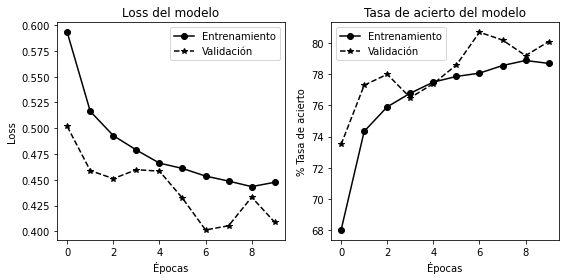

In [50]:
plot_history(history_transfer)
# plt.savefig("Images/Training_CNN_DA_Transfer.png")
plt.show()

In [51]:
model_transfer.load_weights('model_cnn_transfer.h5')

In [52]:
metrics_transfer = evaluate_model(model_transfer, 
                                  train_rdy, validation_rdy, test_rdy)

[Entrenamiento] Loss: 0.370 | Accuracy: 0.835
[Validación] Loss: 0.401 | Accuracy: 0.807
[Test] Loss: 0.404 | Accuracy: 0.827


Vemos que aprovechando las características aprendidas en otro conjunto de datos somos capaces de mejorar los resultados que habíamos obtenido anteriormente. Esta aproximación es muy potente porque nos permite tener un proptipo funcional relativamente rápido, aunque aún se puede mejorar más realizando ajuste fino (o fine-tuning en inglés).

## Fine-Tuning

Una vez hemos entrenado la parte final de nuestra red (la que hemos añadido nosotros que se inicializa aleatoriamente), podemos optar por realizar un último paso: ajuste fino o fine-tuning en inglés.

Esto consiste en descongelar las capas del modelo que hemos importado y entrenar el modelo en conjunto utilizando un *learning rate* muy bajo. De esta forma lo que conseguimos es que los filtros convolucionales se adapten a la tarea específica que intentamos resolver pero minimizando el riesgo de que olviden lo que ya habían aprendido antes. Un learning rate pequeño podría estar en el rango en torno a $10^{-5}$.

Es muy importante que este ajuste fino lo hagamos únicamente después de haber entrenado las capas que añadamos nosotros manualmente. Si no lo hacemos, al estar inicializadas aleatoriamente, no proporcionarán una buena señal al resto de capas y podemos perder todo el conocimiento que tenían aprendido anteriormente.

**Ejercicio: Si recordamos lo que ya se ha comentado, las primeras capas suelen aprender filtros muy generales. Prueba a dejar congeladas las primeras capas y descongelar únicamente las capas más profundas de la red y compara los resultados.**

In [53]:
for layer in model_transfer.layers:
  layer.trainable = True
model_transfer.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-5), 
                       loss="binary_crossentropy", 
                       metrics=["accuracy"])
model_transfer.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 8193      
                                                                 
Total params: 20,032,577
Trainable params: 20,032,577
Non-trainable params: 0
_________________________________________________________________


In [54]:
## Definición de los callbacks
cb_earlystopping = tf.keras.callbacks.EarlyStopping(patience=4,
                                                    monitor='val_accuracy')
cb_modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath='model_cnn_transfer_fine.h5',
                                                        monitor='val_accuracy',
                                                        save_best_only=True)

## Entrenamiento del modelo
history_transfer_fine = model_transfer.fit(train_aug.batch(64), 
                                 epochs=10, 
                                 validation_data=validation_rdy.batch(64),
                                 callbacks=[cb_earlystopping, cb_modelcheckpoint])

Epoch 1/10
125/125 [==============================] - 134s 1s/step - loss: 0.3856 - accuracy: 0.8220 - val_loss: 0.1899 - val_accuracy: 0.9180
Epoch 2/10
125/125 [==============================] - 130s 1s/step - loss: 0.2931 - accuracy: 0.8714 - val_loss: 0.1552 - val_accuracy: 0.9340
Epoch 3/10
125/125 [==============================] - 129s 1s/step - loss: 0.2401 - accuracy: 0.8971 - val_loss: 0.1611 - val_accuracy: 0.9270
Epoch 4/10
125/125 [==============================] - 130s 1s/step - loss: 0.2202 - accuracy: 0.9026 - val_loss: 0.1559 - val_accuracy: 0.9350
Epoch 5/10
125/125 [==============================] - 132s 1s/step - loss: 0.1923 - accuracy: 0.9159 - val_loss: 0.1494 - val_accuracy: 0.9400
Epoch 6/10
125/125 [==============================] - 130s 1s/step - loss: 0.1732 - accuracy: 0.9277 - val_loss: 0.1627 - val_accuracy: 0.9350
Epoch 7/10
125/125 [==============================] - 130s 1s/step - loss: 0.1640 - accuracy: 0.9325 - val_loss: 0.1444 - val_accuracy: 0.9430

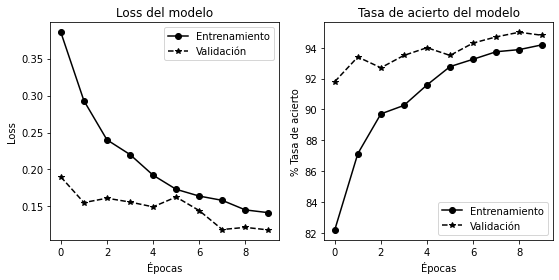

In [55]:
plot_history(history_transfer_fine)
# plt.savefig("Images/Training_CNN_DA_Transfer_Fine.png")
plt.show()

In [56]:
model_transfer.load_weights('model_cnn_transfer_fine.h5')

In [57]:
metrics_transfer_fine = evaluate_model(model_transfer, 
                                       train_rdy, validation_rdy, test_rdy)

[Entrenamiento] Loss: 0.100 | Accuracy: 0.957
[Validación] Loss: 0.122 | Accuracy: 0.950
[Test] Loss: 0.158 | Accuracy: 0.943


Para terminar podemos mostrar un resumen de todas las métricas obtenidas durante la práctica:

Aquí es dónde vemos el potencial que tiene este proceso, los resultados que obtenemos al realizar ajuste fino mejoran considerablemente todos los resultados anteriores. Además, aún podríamos exprimirlo más utilizando diferentes *learning rates* para diferentes partes del modelo, etc.

**Ejercicio: Repite el proceso de transfer learning y fine tuning con otras arquitecturas como ResNet y Inception.**

Como se puede ver, tenemos infinitas posibilidades para afrontar un problema. Podría parecer que las opción lógica sería empezar siempre con un modelo pre-entrenado y ajustarlo a nuestros datos, pero el *no free lunch thorem* nos dice que no existe ninguna solución que siempre vaya a proporcionarnos el mejor resultado posible. Los modelos personalizados nos dan muchas más posibilidades que los modelos pre-entrenados pero pueden darnos peores resultados si no tenemos muchos datos. En estos casos, el transfer learning suele ser una buena alternativa. Además, utilizar modelos pre-entrenados nos da la posibilidad de crear prototipos funcionales muy rápido a costa de perder personalización.